# Training a LightGBM model

In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import scipy
import lightgbm as lgb

In [2]:
gp = pd.read_csv('aggregated_features.csv')

In [3]:
train = pd.read_csv('train.csv', parse_dates=['activation_date'])
test = pd.read_csv('test.csv', parse_dates=['activation_date'])

train = train.merge(gp, on='user_id', how='left')
test = test.merge(gp, on='user_id', how='left')

agg_cols = list(gp.columns)[1:]

del gp; gc.collect()

train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,activation_date,user_type,image,image_top_1,deal_probability,avg_days_up_user,avg_times_up_user,med_days_up_user,med_times_up_user,n_user_items
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789,8.000000,2.000000,8.0,2.0,2.0
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000,NaN,NaN,NaN,NaN,NaN
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177,4.428571,1.142857,3.0,1.0,9.0
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323,16.714286,2.642857,18.0,3.0,32.0
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797,NaN,NaN,NaN,NaN,NaN


In [4]:
train = train.sort_values(['activation_date']).reset_index(drop=True)

In [5]:
train_index, valid_index = train_test_split(np.arange(len(train)), test_size=0.1, random_state=519)

In [6]:
train.loc[train_index, 'activation_date'].dt.weekday.value_counts()

0    207048
6    205318
1    201131
2    196631
3    191293
4    176527
5    175133
Name: activation_date, dtype: int64

In [7]:
train.loc[valid_index, 'activation_date'].dt.weekday.value_counts()

0    23007
6    22614
1    22289
2    21884
3    21422
4    19599
5    19528
Name: activation_date, dtype: int64

In [8]:
test.loc[:, 'activation_date'].dt.weekday.value_counts()

2    81888
1    81114
0    80191
3    77177
4    70366
6    58909
5    58793
Name: activation_date, dtype: int64

One more thing about the approach that I haven't mentioned yet is that we will have quite some NaN values because not every ID in `train` and `test` occurs in `train_active` and `test_active`. Let's check how big that problem is.

In [9]:
train[agg_cols].isnull().any(axis=1).sum() / len(train) * 100

22.407185198586692

In [10]:
test[agg_cols].isnull().any(axis=1).sum() / len(test) * 100

24.354198545348694

In [11]:
train.isnull().sum(), test.isnull().sum()

(item_id                      0
 user_id                      0
 region                       0
 city                         0
 parent_category_name         0
 category_name                0
 param_1                  61576
 param_2                 654542
 param_3                 862565
 title                        0
 description             116276
 price                    85362
 item_seq_number              0
 activation_date              0
 user_type                    0
 image                   112588
 image_top_1             112588
 deal_probability             0
 avg_days_up_user        336875
 avg_times_up_user       336875
 med_days_up_user        336875
 med_times_up_user       336875
 n_user_items            336875
 dtype: int64, item_id                      0
 user_id                      0
 region                       0
 city                         0
 parent_category_name         0
 category_name                0
 param_1                  22910
 param_2                 2

We have missing features for 22.41% of train and 24.35% of test data. That's not perfect but certainly acceptable. Onto some more basic feature engineering with ideas from [a great kernel](https://www.kaggle.com/tunguz/bow-meta-text-and-dense-features-lb-0-2241?scriptVersionId=3603709).

In [12]:
import string

In [13]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])


for df in [train, test]:
    df['description'].fillna('unknowndescription', inplace=True)
    df['title'].fillna('unknowntitle', inplace=True)

    df['weekday'] = pd.to_datetime(df['activation_date']).dt.day
    
    for col in ['description', 'title']:
        df['num_words_' + col] = df[col].apply(lambda comment: len(comment.split()))
        df['num_unique_words_' + col] = df[col].apply(lambda comment: len(set(w for w in comment.split())))

    df['words_vs_unique_title'] = df['num_unique_words_title'] / df['num_words_title'] * 100
    df['words_vs_unique_description'] = df['num_unique_words_description'] / df['num_words_description'] * 100
    
    df['city'] = df['region'] + '_' + df['city']
    df['num_desc_punct'] = df['description'].apply(lambda x: count(x, set(string.punctuation)))
    
    for col in agg_cols:
        df[col].fillna(-1, inplace=True)
    
    for col in ['price', 'image_top_1']:
         df[col].fillna(-1, inplace=True)
            
    for col in ['param_1', 'param_2', 'param_3']:
         df[col].fillna('khwinkaggle', inplace=True)

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\viola\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
count_vectorizer_title = CountVectorizer(stop_words=stopwords.words('russian'), lowercase=True, min_df=25)

title_counts = count_vectorizer_title.fit_transform(train['title'].append(test['title']))

train_title_counts = title_counts[:len(train)]
test_title_counts = title_counts[len(train):]


count_vectorizer_desc = TfidfVectorizer(stop_words=stopwords.words('russian'), 
                                        lowercase=True, ngram_range=(1, 2),
                                        max_features=15000)

desc_counts = count_vectorizer_desc.fit_transform(train['description'].append(test['description']))

train_desc_counts = desc_counts[:len(train)]
test_desc_counts = desc_counts[len(train):]

train_title_counts.shape, train_desc_counts.shape

((1503424, 16447), (1503424, 15000))

In [16]:
target = 'deal_probability'
predictors = [
    'num_desc_punct', 
    'words_vs_unique_description', 'num_unique_words_description', 'num_unique_words_title', 'num_words_description', 'num_words_title',
    'avg_times_up_user', 'avg_days_up_user', 'n_user_items', 
    'price', 'item_seq_number'
]
categorical = [
    'image_top_1', 'param_1', 'param_2', 'param_3', 
    'city', 'region', 'category_name', 'parent_category_name', 'user_type'
]

predictors = predictors + categorical

In [17]:
for feature in categorical:
    print(f'Transforming {feature}...')
    encoder = LabelEncoder()
    encoder.fit(train[feature].append(test[feature]).astype(str))
    
    train[feature] = encoder.transform(train[feature].astype(str))
    test[feature] = encoder.transform(test[feature].astype(str))

Transforming image_top_1...
Transforming param_1...
Transforming param_2...
Transforming param_3...
Transforming city...
Transforming region...
Transforming category_name...
Transforming parent_category_name...
Transforming user_type...


After some hyperparameter definitions and creating train / valid / test matrices, we can finally train the model. Let's see if the aggregated features helped.

*Note: For further feature engineering, I would recommend restricting the max_depth further (5 worked well for me) and increasing the learning rate (to ~ 0.1) so you don't have to wait forever for the training to finish.*

In [18]:
rounds = 24000
early_stop_rounds = 200
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 48,
    'max_depth': 15,
    'learning_rate' : 0.02,
    'feature_fraction' : 0.6,
    'verbosity' : -1
}

feature_names = np.hstack([
    count_vectorizer_desc.get_feature_names(),
    count_vectorizer_title.get_feature_names(),
    predictors
])
print('Number of features:', len(feature_names))

Number of features: 31467


In [19]:
from sklearn.model_selection import KFold
kf = KFold(5, shuffle=True, random_state=411)

In [20]:
x_test = scipy.sparse.hstack([
    test_desc_counts,
    test_title_counts,
    test.loc[:, predictors]
], format='csr')

In [21]:
ret = np.zeros((train.shape[0],))
ret_test = np.zeros((x_test.shape[0],))
ret_models = []
    
for train_ix, val_ix in kf.split(train):
    x_train = scipy.sparse.hstack([
        train_desc_counts[train_ix],
        train_title_counts[train_ix],
        train.loc[train_ix, predictors]
    ], format='csr')
    y_train = train.loc[train_ix, target]
    
    x_valid = scipy.sparse.hstack([
        train_desc_counts[val_ix],
        train_title_counts[val_ix],
        train.loc[val_ix, predictors]
    ], format='csr')
    y_valid = train.loc[val_ix, target]
    
    dtrain = lgb.Dataset(x_train, label=y_train,
                         feature_name=list(feature_names), 
                         categorical_feature=categorical)
    dvalid = lgb.Dataset(x_valid, label=y_valid,
                         feature_name=list(feature_names), 
                         categorical_feature=categorical)
    
    model = lgb.train(params, dtrain, 
                      valid_sets=[dtrain, dvalid], 
                      valid_names=['train', 'valid'],
                      num_boost_round=rounds, 
                      early_stopping_rounds=early_stop_rounds, 
                      verbose_eval=100)
    
    ret[val_ix] = model.predict(x_valid)
    ret_test += model.predict(x_test)
    ret_models.append(model)
    
    del x_train, y_train, x_valid, y_valid, dtrain, dvalid

E:\Anaconda3\lib\site-packages\lightgbm\basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.228141	valid's rmse: 0.229112
[200]	train's rmse: 0.22355	valid's rmse: 0.225547
[300]	train's rmse: 0.220796	valid's rmse: 0.223783
[400]	train's rmse: 0.219092	valid's rmse: 0.222865
[500]	train's rmse: 0.217913	valid's rmse: 0.22228
[600]	train's rmse: 0.216963	valid's rmse: 0.221866
[700]	train's rmse: 0.216158	valid's rmse: 0.221532
[800]	train's rmse: 0.215481	valid's rmse: 0.221277
[900]	train's rmse: 0.214836	valid's rmse: 0.221023
[1000]	train's rmse: 0.214268	valid's rmse: 0.220826
[1100]	train's rmse: 0.213764	valid's rmse: 0.220649
[1200]	train's rmse: 0.213273	valid's rmse: 0.22049
[1300]	train's rmse: 0.212822	valid's rmse: 0.22036
[1400]	train's rmse: 0.212349	valid's rmse: 0.220228
[1500]	train's rmse: 0.211926	valid's rmse: 0.220111
[1600]	train's rmse: 0.211526	valid's rmse: 0.220012
[1700]	train's rmse: 0.211131	valid's rmse: 0.219911
[1800]	train's rmse: 0.210756	valid's rmse: 0.219

[3300]	train's rmse: 0.20616	valid's rmse: 0.220148
[3400]	train's rmse: 0.205919	valid's rmse: 0.220123
[3500]	train's rmse: 0.205682	valid's rmse: 0.220096
[3600]	train's rmse: 0.205444	valid's rmse: 0.220066
[3700]	train's rmse: 0.20522	valid's rmse: 0.220043
[3800]	train's rmse: 0.204996	valid's rmse: 0.220018
[3900]	train's rmse: 0.204773	valid's rmse: 0.219992
[4000]	train's rmse: 0.204541	valid's rmse: 0.219971
[4100]	train's rmse: 0.204327	valid's rmse: 0.219952
[4200]	train's rmse: 0.204075	valid's rmse: 0.219921
[4300]	train's rmse: 0.203869	valid's rmse: 0.2199
[4400]	train's rmse: 0.203649	valid's rmse: 0.219878
[4500]	train's rmse: 0.203441	valid's rmse: 0.219855
[4600]	train's rmse: 0.203231	valid's rmse: 0.219834
[4700]	train's rmse: 0.202997	valid's rmse: 0.219806
[4800]	train's rmse: 0.202796	valid's rmse: 0.219793
[4900]	train's rmse: 0.202589	valid's rmse: 0.219775
[5000]	train's rmse: 0.202387	valid's rmse: 0.219764
[5100]	train's rmse: 0.202183	valid's rmse: 0.2197

[5700]	train's rmse: 0.201328	valid's rmse: 0.21813
[5800]	train's rmse: 0.201137	valid's rmse: 0.218118
[5900]	train's rmse: 0.200966	valid's rmse: 0.21811
[6000]	train's rmse: 0.200778	valid's rmse: 0.218094
[6100]	train's rmse: 0.200592	valid's rmse: 0.218085
[6200]	train's rmse: 0.200415	valid's rmse: 0.218081
[6300]	train's rmse: 0.200235	valid's rmse: 0.218068
[6400]	train's rmse: 0.20006	valid's rmse: 0.21806
[6500]	train's rmse: 0.199886	valid's rmse: 0.218051
[6600]	train's rmse: 0.199705	valid's rmse: 0.218037
[6700]	train's rmse: 0.199521	valid's rmse: 0.218023
[6800]	train's rmse: 0.199336	valid's rmse: 0.218013
[6900]	train's rmse: 0.199173	valid's rmse: 0.218005
[7000]	train's rmse: 0.198989	valid's rmse: 0.217992
[7100]	train's rmse: 0.198802	valid's rmse: 0.217981
[7200]	train's rmse: 0.198625	valid's rmse: 0.217974
[7300]	train's rmse: 0.198437	valid's rmse: 0.217963
[7400]	train's rmse: 0.19825	valid's rmse: 0.217957
[7500]	train's rmse: 0.19808	valid's rmse: 0.217952

[9400]	train's rmse: 0.19469	valid's rmse: 0.21813
[9500]	train's rmse: 0.194534	valid's rmse: 0.218121
[9600]	train's rmse: 0.19437	valid's rmse: 0.218119
[9700]	train's rmse: 0.194206	valid's rmse: 0.218111
[9800]	train's rmse: 0.194054	valid's rmse: 0.218108
[9900]	train's rmse: 0.193907	valid's rmse: 0.218105
[10000]	train's rmse: 0.193734	valid's rmse: 0.218102
[10100]	train's rmse: 0.193581	valid's rmse: 0.218096
[10200]	train's rmse: 0.193433	valid's rmse: 0.218095
[10300]	train's rmse: 0.193271	valid's rmse: 0.218089
[10400]	train's rmse: 0.19314	valid's rmse: 0.218085
[10500]	train's rmse: 0.192991	valid's rmse: 0.218083
[10600]	train's rmse: 0.192841	valid's rmse: 0.21808
[10700]	train's rmse: 0.1927	valid's rmse: 0.218076
[10800]	train's rmse: 0.192554	valid's rmse: 0.218073
[10900]	train's rmse: 0.192403	valid's rmse: 0.218069
[11000]	train's rmse: 0.192264	valid's rmse: 0.218066
[11100]	train's rmse: 0.192128	valid's rmse: 0.218064
[11200]	train's rmse: 0.191982	valid's rm

In [ ]:
[11856]	train's rmse: 0.191193	valid's rmse: 0.218151
[12791]	train's rmse: 0.189806	valid's rmse: 0.219294
[11411]	train's rmse: 0.191963	valid's rmse: 0.217746
[11515]	train's rmse: 0.191517	valid's rmse: 0.218047
[10637]	train's rmse: 0.192627	valid's rmse: 0.21873

In [22]:
ret_test = ret_test / 5.

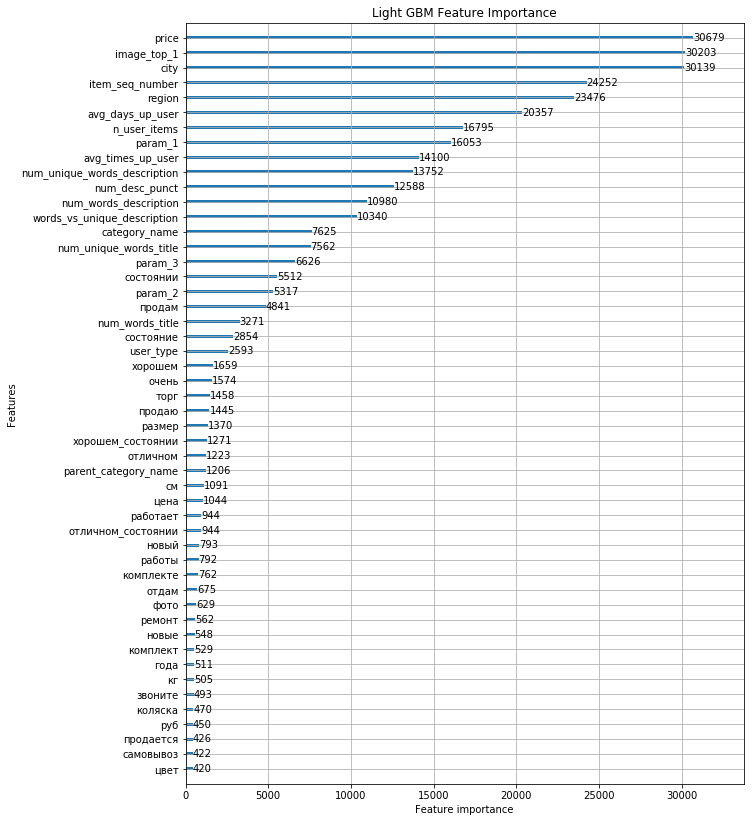

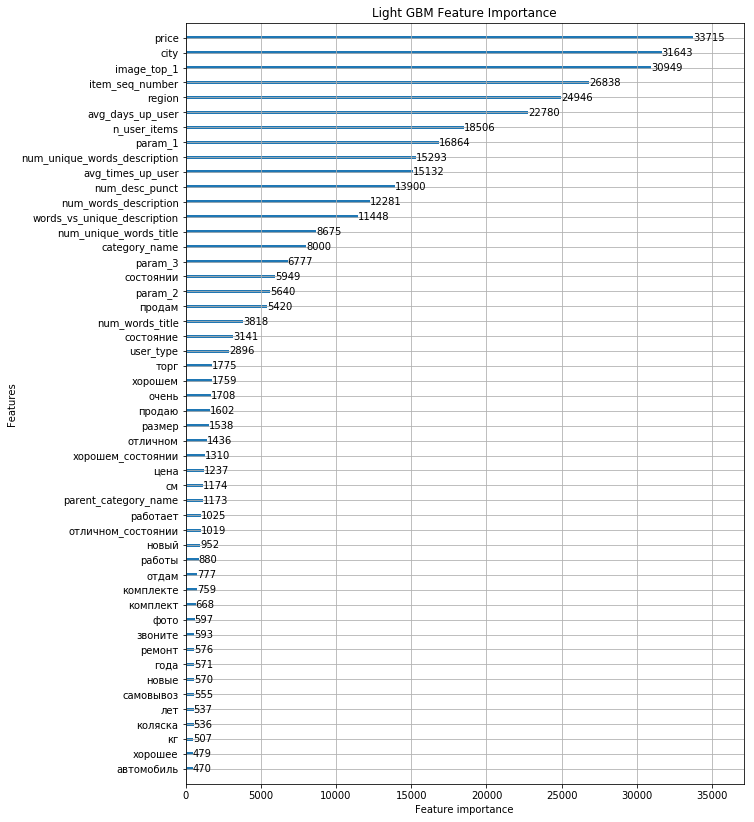

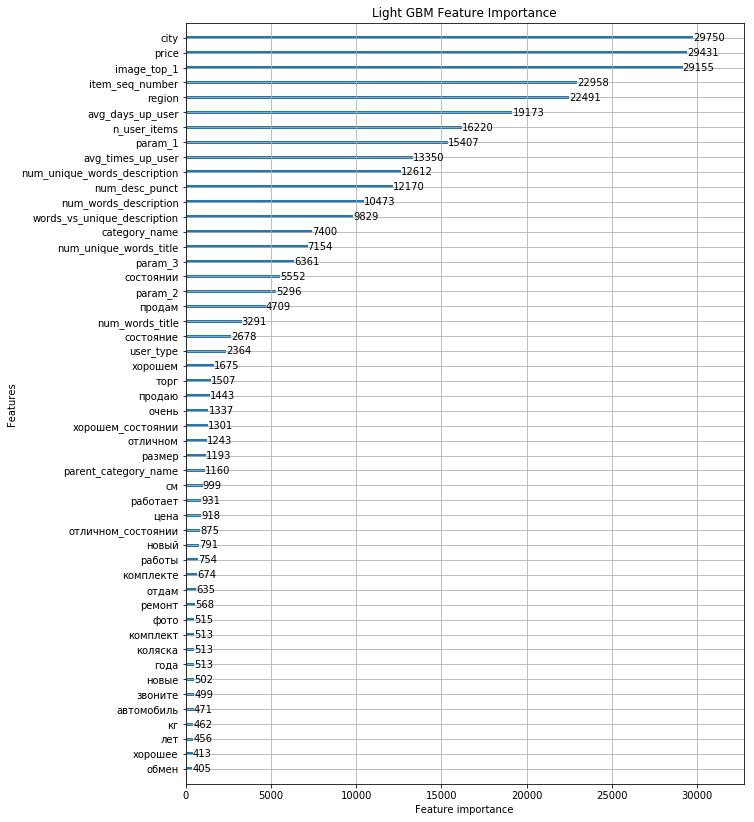

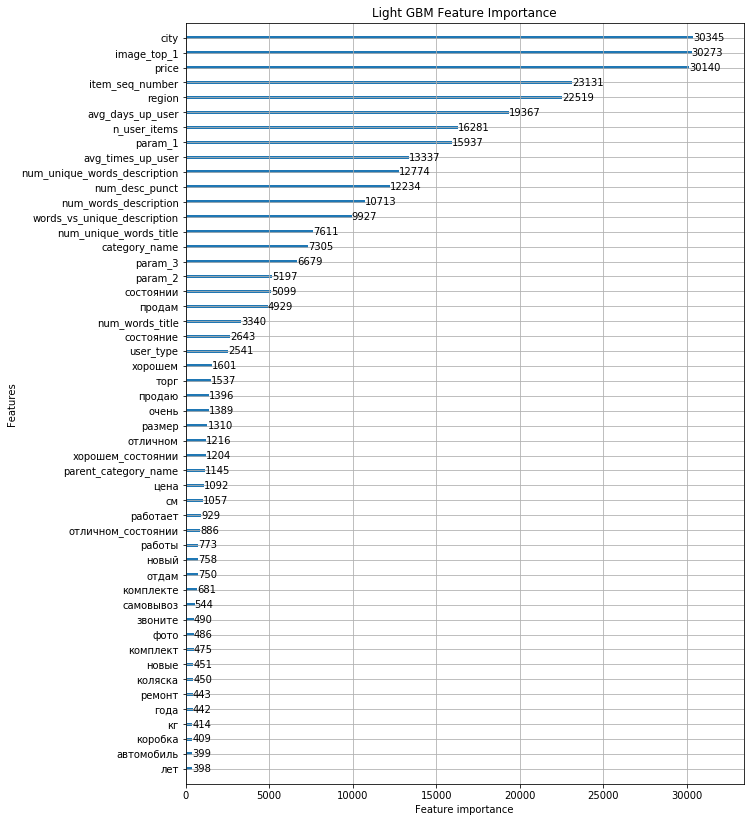

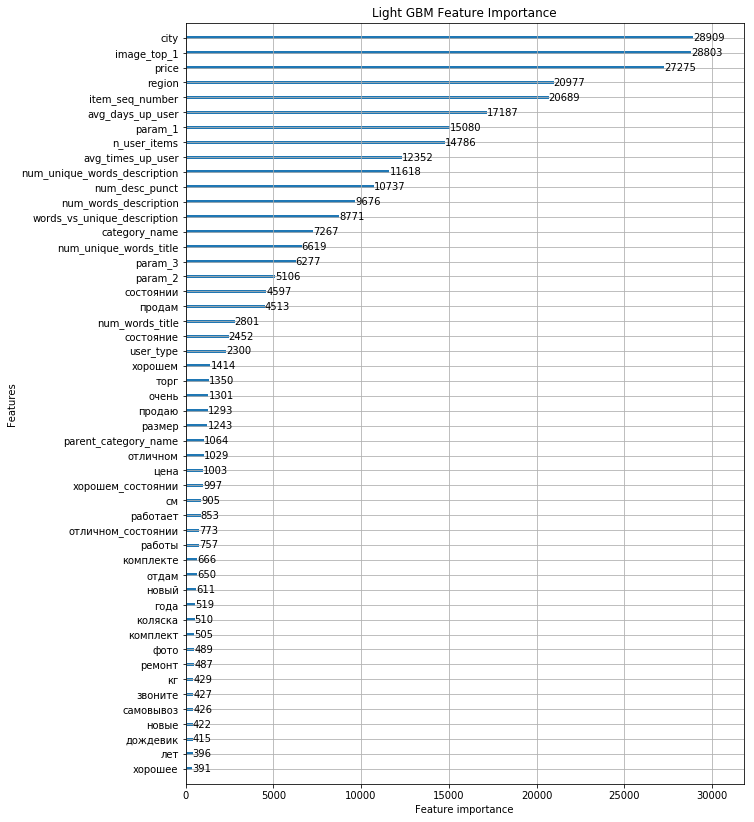

In [23]:
for model in ret_models:
    fig, ax = plt.subplots(figsize=(10, 14))
    lgb.plot_importance(model, max_num_features=50, ax=ax)
    plt.title("Light GBM Feature Importance")
    plt.show()

That looks good. But the model is kind of a black box. It is a good idea to plot the feature importances for our model now.

`avg_days_up`, `avg_times_up_user` and `n_user_items` are our most important engineered features! Looks like we were successful. Now we just have to predict the test matrix and submit!

In [24]:
pd.DataFrame(data=ret, columns=['simple_feature2_lgb_pred']).to_csv('simple_feature2_lgb_oof_val_pred.csv', index=False)
pd.DataFrame(data=ret_test, columns=['simple_feature2_lgb_pred']).to_csv('simple_feature2_lgb_oof_test_pred.csv', index=False)

In [25]:
subm = pd.read_csv('sample_submission.csv')
subm['deal_probability'] = np.clip(ret_test, 0, 1)
subm.to_csv('simple_feature2_submission.csv', index=False)

In [26]:
import pickle
for md in ret_models:
    with open('models/simple2_feature_lgb.model', 'wb') as handle:
        pickle.dump(md, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
ret_test

array([ 0.27222526,  0.14373176,  0.21090215, ...,  0.06344379,
        0.29844334,  0.06710444])

I'll end this kernel with some ideas to improve it:
- Use K-Fold cross validation.
- Try other methods than mean for reducing the aggregated features to one per user (e. g. modus or median).
- Try other gradient boosting libraries like CatBoost or XGBoost.
- Add a temporal dimension to engineered features (e. g. # of items a user put up for sale *per day*).
- Add more advanced text features like pretrained word embeddings.
- Add image features. At the moment we completely ignore images! (as discussed [here](https://www.kaggle.com/c/avito-demand-prediction/discussion/56678), two promising approaches could be [NIMA: Neural Image Assessment](https://arxiv.org/abs/1709.05424) and [Multimedia Features for Click Prediction](https://storage.googleapis.com/kaggle-forum-message-attachments/328059/9411/dimitri-clickadvert.pdf)).
- Normalize text before creating the Tf-Idf matrix (e. g. using [stemming](http://www.nltk.org/howto/stem.html)).
- ~~Learn russian and do in-depth text analysis.~~

Thanks for reading and have fun in this competition!